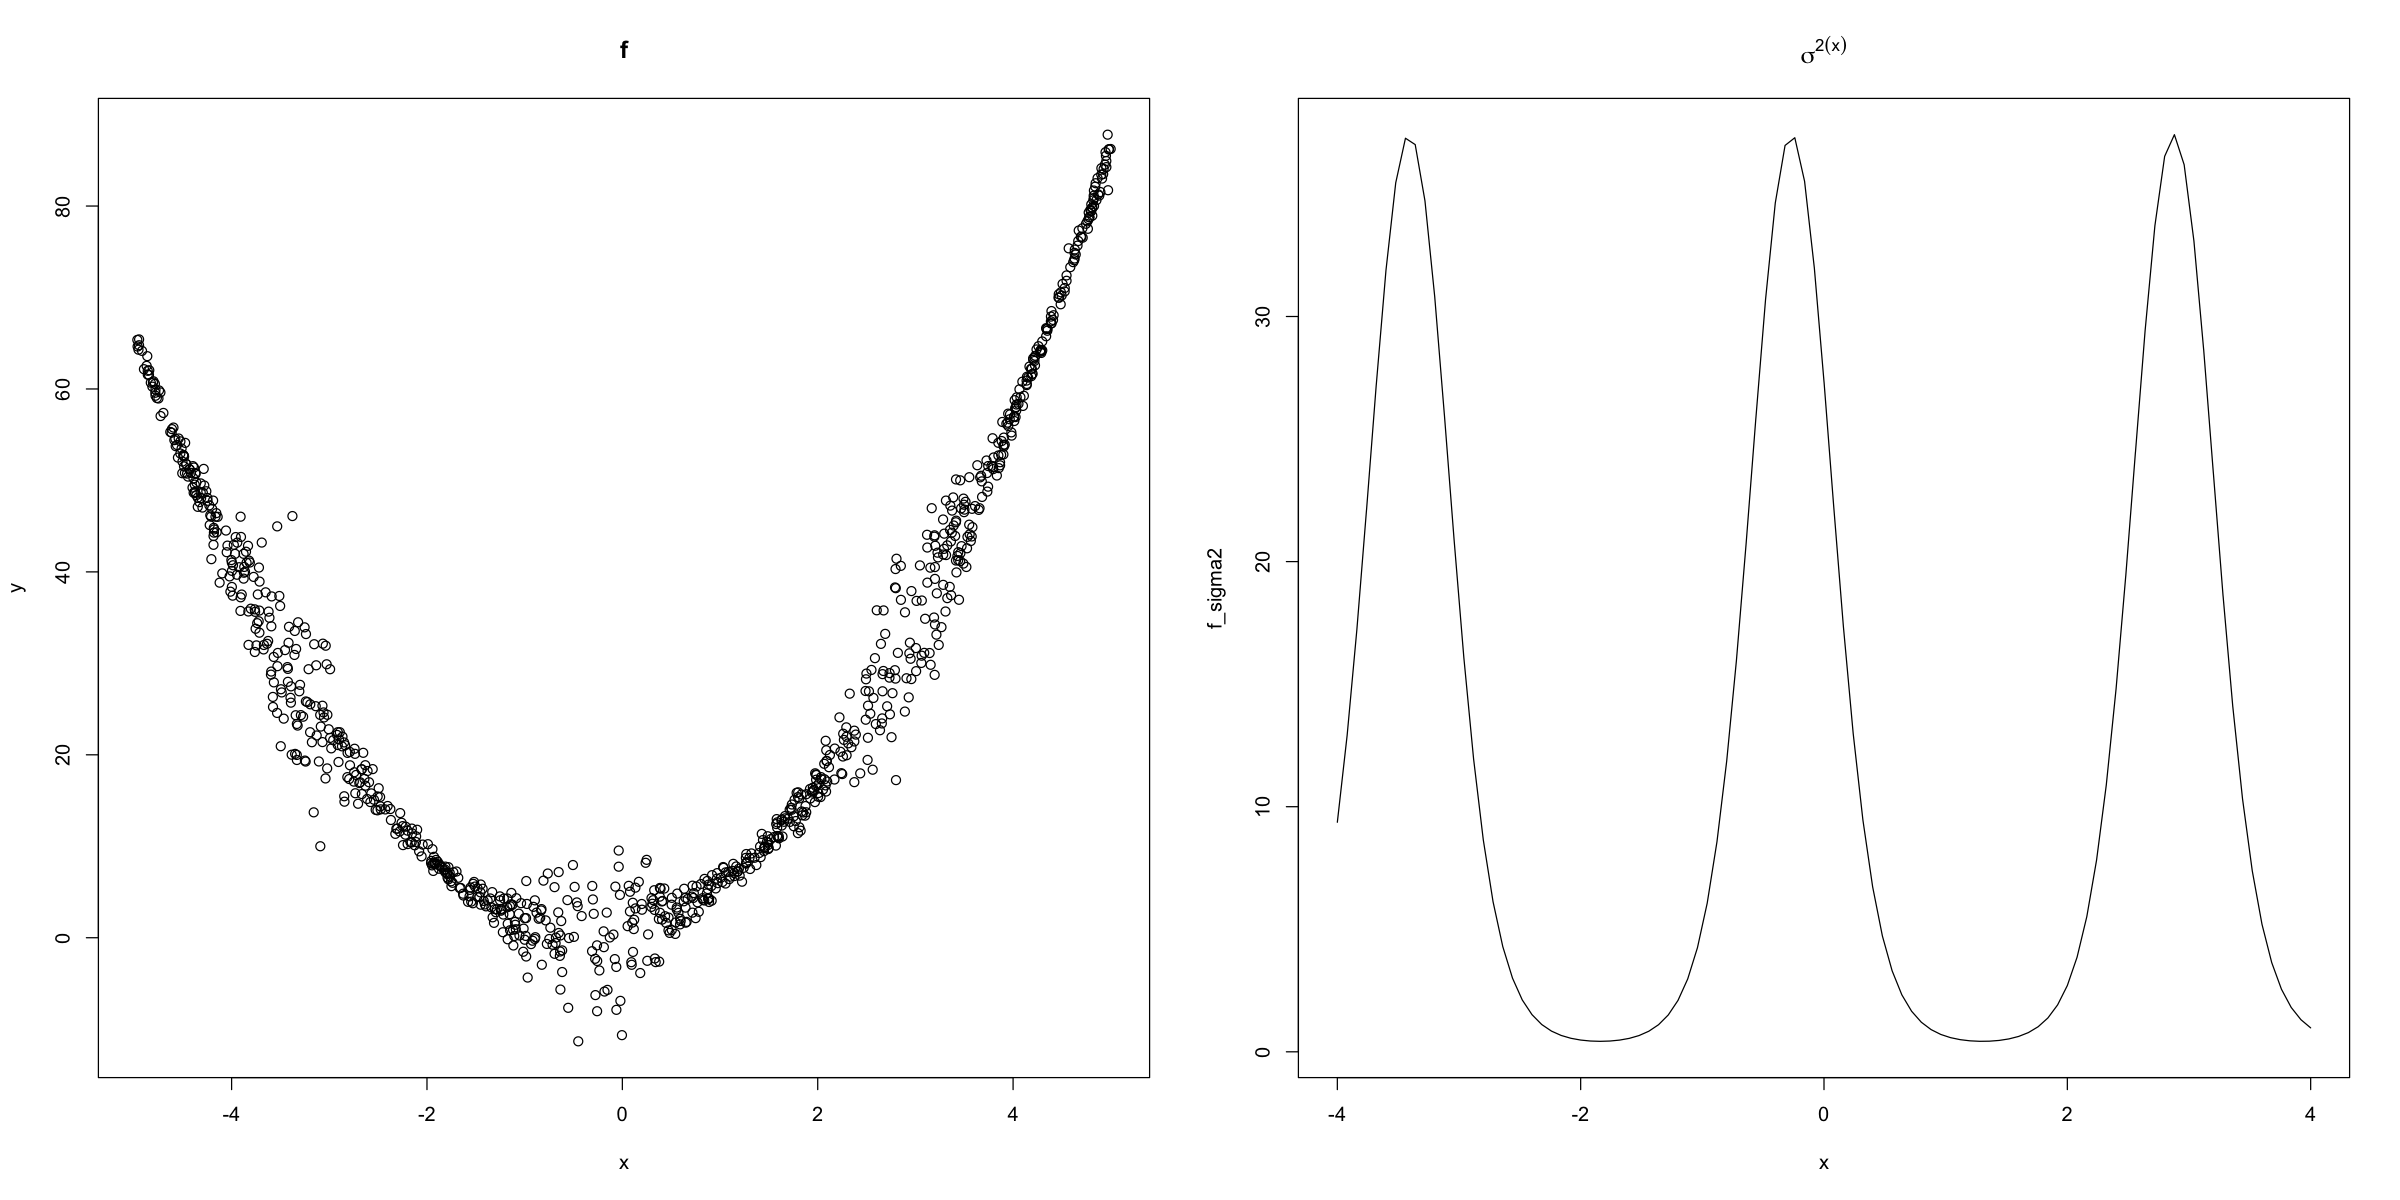

In [26]:
library(torch)

n = 1000
x = runif(n, -5,5)
f = function(x) 1 + 3 * x^2 + 2 * x
f_sigma2 = function(x) 4*exp(1*sin(1 + 2*x) + 2*cos(1 + 2*x))
y = f(x) + rnorm(n)*sqrt(f_sigma2(x))

options(
  repr.plot.width = 20,
  repr.plot.height = 10
)
par(mfrow = c(1, 2))

plot(y ~ x, main = "f")
plot(f_sigma2, xlim = c(-4, 4), main = expression(sigma^2(x)))
par(mfrow = c(1, 1))  # (opcional) volta ao normal

model_mu_sigma2 <- torch::nn_module (
  initialize = function (in_dim, out_dim, N) {
    self$seq_mu <- torch::nn_sequential (
      torch::nn_linear(in_dim, round(N)),
      torch::nn_gelu(),
      torch::nn_linear(round(N), out_dim)
    )
    self$seq_logsig2 <- torch::nn_sequential(
      torch::nn_linear(in_dim, round(N)),
      torch::nn_gelu(),
      torch::nn_linear(round(N), out_dim)
    )
    self$gif_dir <- file.path(tempdir(), "frames_gif")
    dir.create(self$gif_dir, showWarnings = FALSE, recursive = TRUE)
    # LIMPA frames antigos
    old <- list.files(self$gif_dir, pattern="\\.png$", full.names=TRUE)
    if (length(old) > 0) file.remove(old)
    self$gif_idx <- 0L
  },
  forward = function(x) {
    mu <- self$seq_mu(x)
    sigma2 <- torch_exp(self$seq_logsig2(x))
    return(list(mu, sigma2))
  }
)

In [27]:
estimacao <- function(x, y, model, epochs = 3000, lr = 1e-3, print_each = 10,
                      f, f_sigma2, make_gif = FALSE, gif_every = 10, gif_name = "train.gif") {

  n <- length(x)

  xx <- torch::torch_tensor(matrix(x, ncol = 1), dtype = torch::torch_float())
  yy <- torch::torch_tensor(matrix(y, ncol = 1), dtype = torch::torch_float())

  optim <- optim_adam(model$parameters, lr = lr)

  x1  <- seq(-5, 5, length.out = 300)
  x1t <- torch::torch_tensor(matrix(x1, ncol = 1), dtype = torch::torch_float())

  # --- FIXA O QUADRO DO SIGMA2 (uma vez, fora do loop) ---
  s2_true_x1  <- f_sigma2(x1)
  ymax_sigma2 <- as.numeric(stats::quantile(s2_true_x1, probs = 0.98, na.rm = TRUE))
  ylim_sigma2 <- c(0, 1.10 * ymax_sigma2)

  loss_store <- rep(NA, epochs)

  # (opcional, mas bom) garantir que existe se for salvar frames
  if (make_gif) {
    dir.create(model$gif_dir, showWarnings = FALSE, recursive = TRUE)
  }

  for (i in 1:epochs) {

    loss_i <- 0

    for (j in 1:n) {

      fit    <- model(xx[j, ..])
      yhat   <- fit[[1]]
      sigma2 <- fit[[2]]

      L <- (0.5 * torch::torch_log(sigma2) +
              0.5 * (yy[j, ..] - yhat)^2 / sigma2)$sum()

      optim$zero_grad()
      L$backward()
      optim$step()

      loss_i <- loss_i + as.numeric(L$item())
    }

    loss_store[i] <- loss_i / n

    if (i %% print_each == 0) {

      with_no_grad({
        fit1 <- model(x1t)
        mu1  <- as.numeric(fit1[[1]]$squeeze())
        s21  <- as.numeric(fit1[[2]]$squeeze())
      })

      IRdisplay::clear_output(wait = TRUE)
      cat(sprintf("Epoca: %d   Perda: %.6f\n", i, loss_store[i]))

      panel <- make_panel(
        x, y, x1, mu1, s21, loss_store, i, f, f_sigma2,
        ylim_sigma2 = ylim_sigma2
      )
      print(panel)

      if (make_gif && (i %% gif_every == 0)) {
        model$gif_idx <- model$gif_idx + 1L
        png(file.path(model$gif_dir, sprintf("frame_%05d.png", model$gif_idx)),
            width = 1600, height = 450, res = 150)
        cat(sprintf("Epoca: %d   Perda: %.6f\n", i, loss_store[i]))
        print(panel)
        dev.off()
      }
    }
  }

  if (make_gif) {
    frames <- sort(list.files(model$gif_dir, pattern = "\\.png$", full.names = TRUE))
    gifski::gifski(png_files = frames, gif_file = gif_name, width = 1600, height = 450, delay = 0.08)
    cat("\nGIF gerado em: ", gif_name, "\n")
  }

  invisible(list(model = model, loss_store = loss_store))
}

In [28]:
library(IRdisplay)
library(ggplot2)
library(patchwork)
library(gifski)

In [29]:
make_panel <- function(x, y, x1, mu1, s21, loss_store, i, f, f_sigma2, ylim_sigma2 = NULL) {

  df_data <- data.frame(x = x, y = y)

  df_grid <- data.frame(
    x      = x1,
    mu     = mu1,
    s2     = s21,
    ftrue  = f(x1),
    s2true = f_sigma2(x1)
  )

  df_loss <- data.frame(
    iter = 1:i,
    loss = log(loss_store[1:i])
  )

  # -------- Panel 1: f(x) --------
  p1 <- ggplot(df_data, aes(x, y)) +
    geom_point(size = 1, alpha = 0.7) +
    geom_line(data = df_grid, aes(x, ftrue), linewidth = 0.9) +
    geom_point(data = df_grid, aes(x, mu), color = "tomato", size = 0.9) +
    labs(title = "f(x): verdadeiro vs aprendido", x = "x", y = "y")

  # -------- Panel 2: sigma2(x) --------
  p2 <- ggplot(df_grid, aes(x, s2true)) +
    geom_line(linewidth = 0.9) +
    geom_point(aes(x, s2), color = "tomato", size = 0.9) +
    coord_cartesian(xlim = c(-4, 4), ylim = ylim_sigma2) +
    labs(title = "sigma2(x): verdadeiro vs aprendido", x = "x", y = "sigma2")

  # -------- Panel 3: loss --------
  p3 <- ggplot(df_loss, aes(iter, loss)) +
    geom_point(size = 1, alpha = 0.8) +
    labs(title = "log(loss) vs iter", x = "Iteração", y = "log(loss)")

  p1 | p2 | p3
}

In [30]:
model = model_mu_sigma2(1, 1, 10)

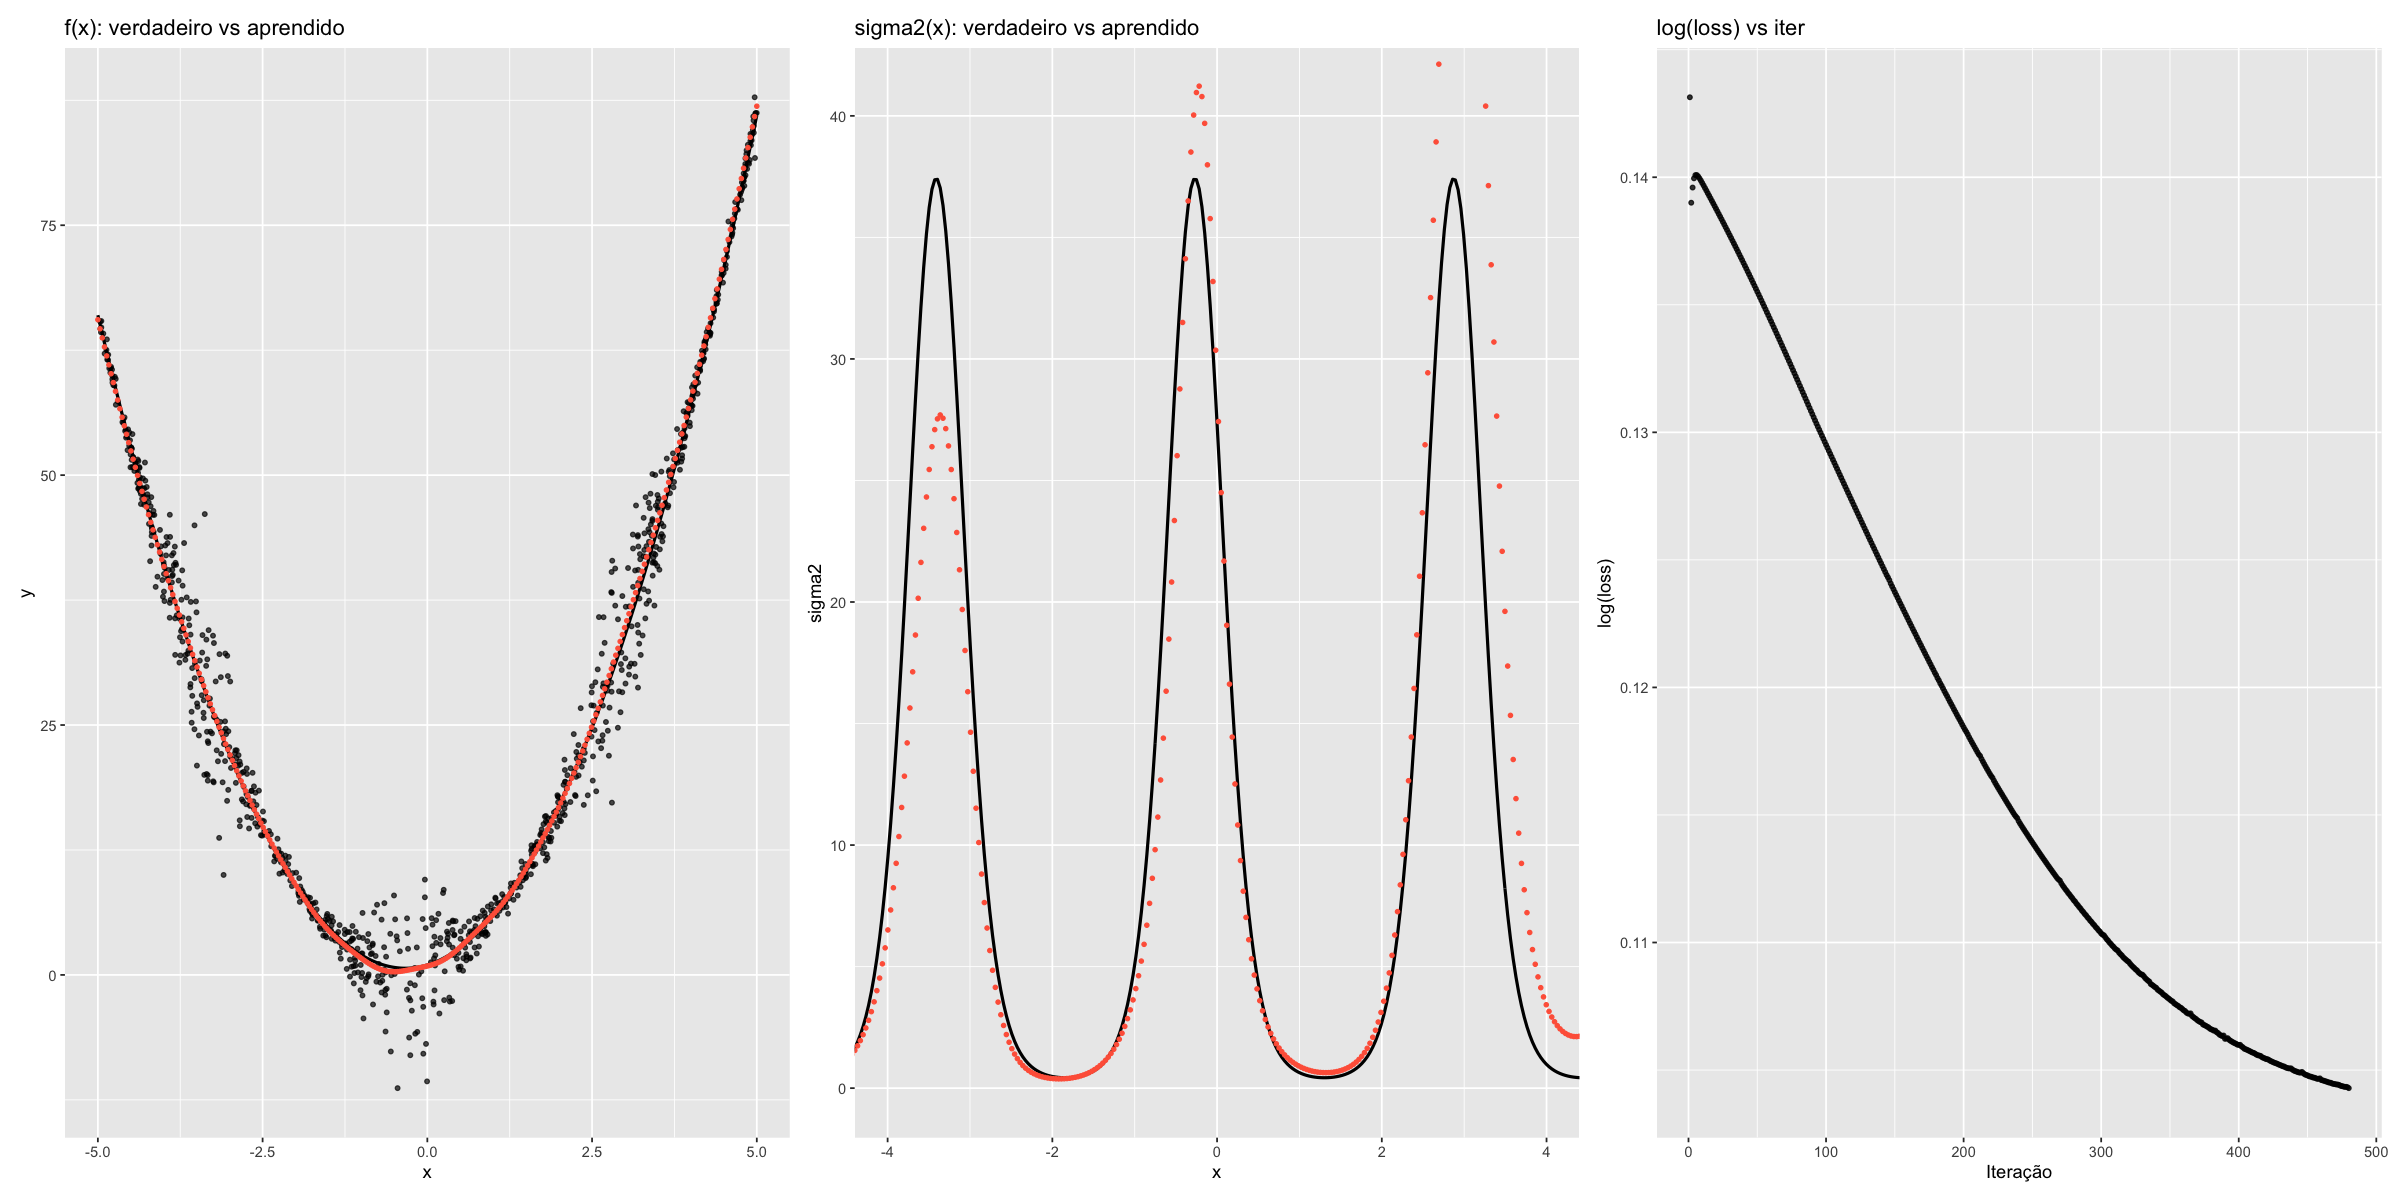

Epoca: 500   Perda: 1.109644
Epoca: 500   Perda: 1.109644


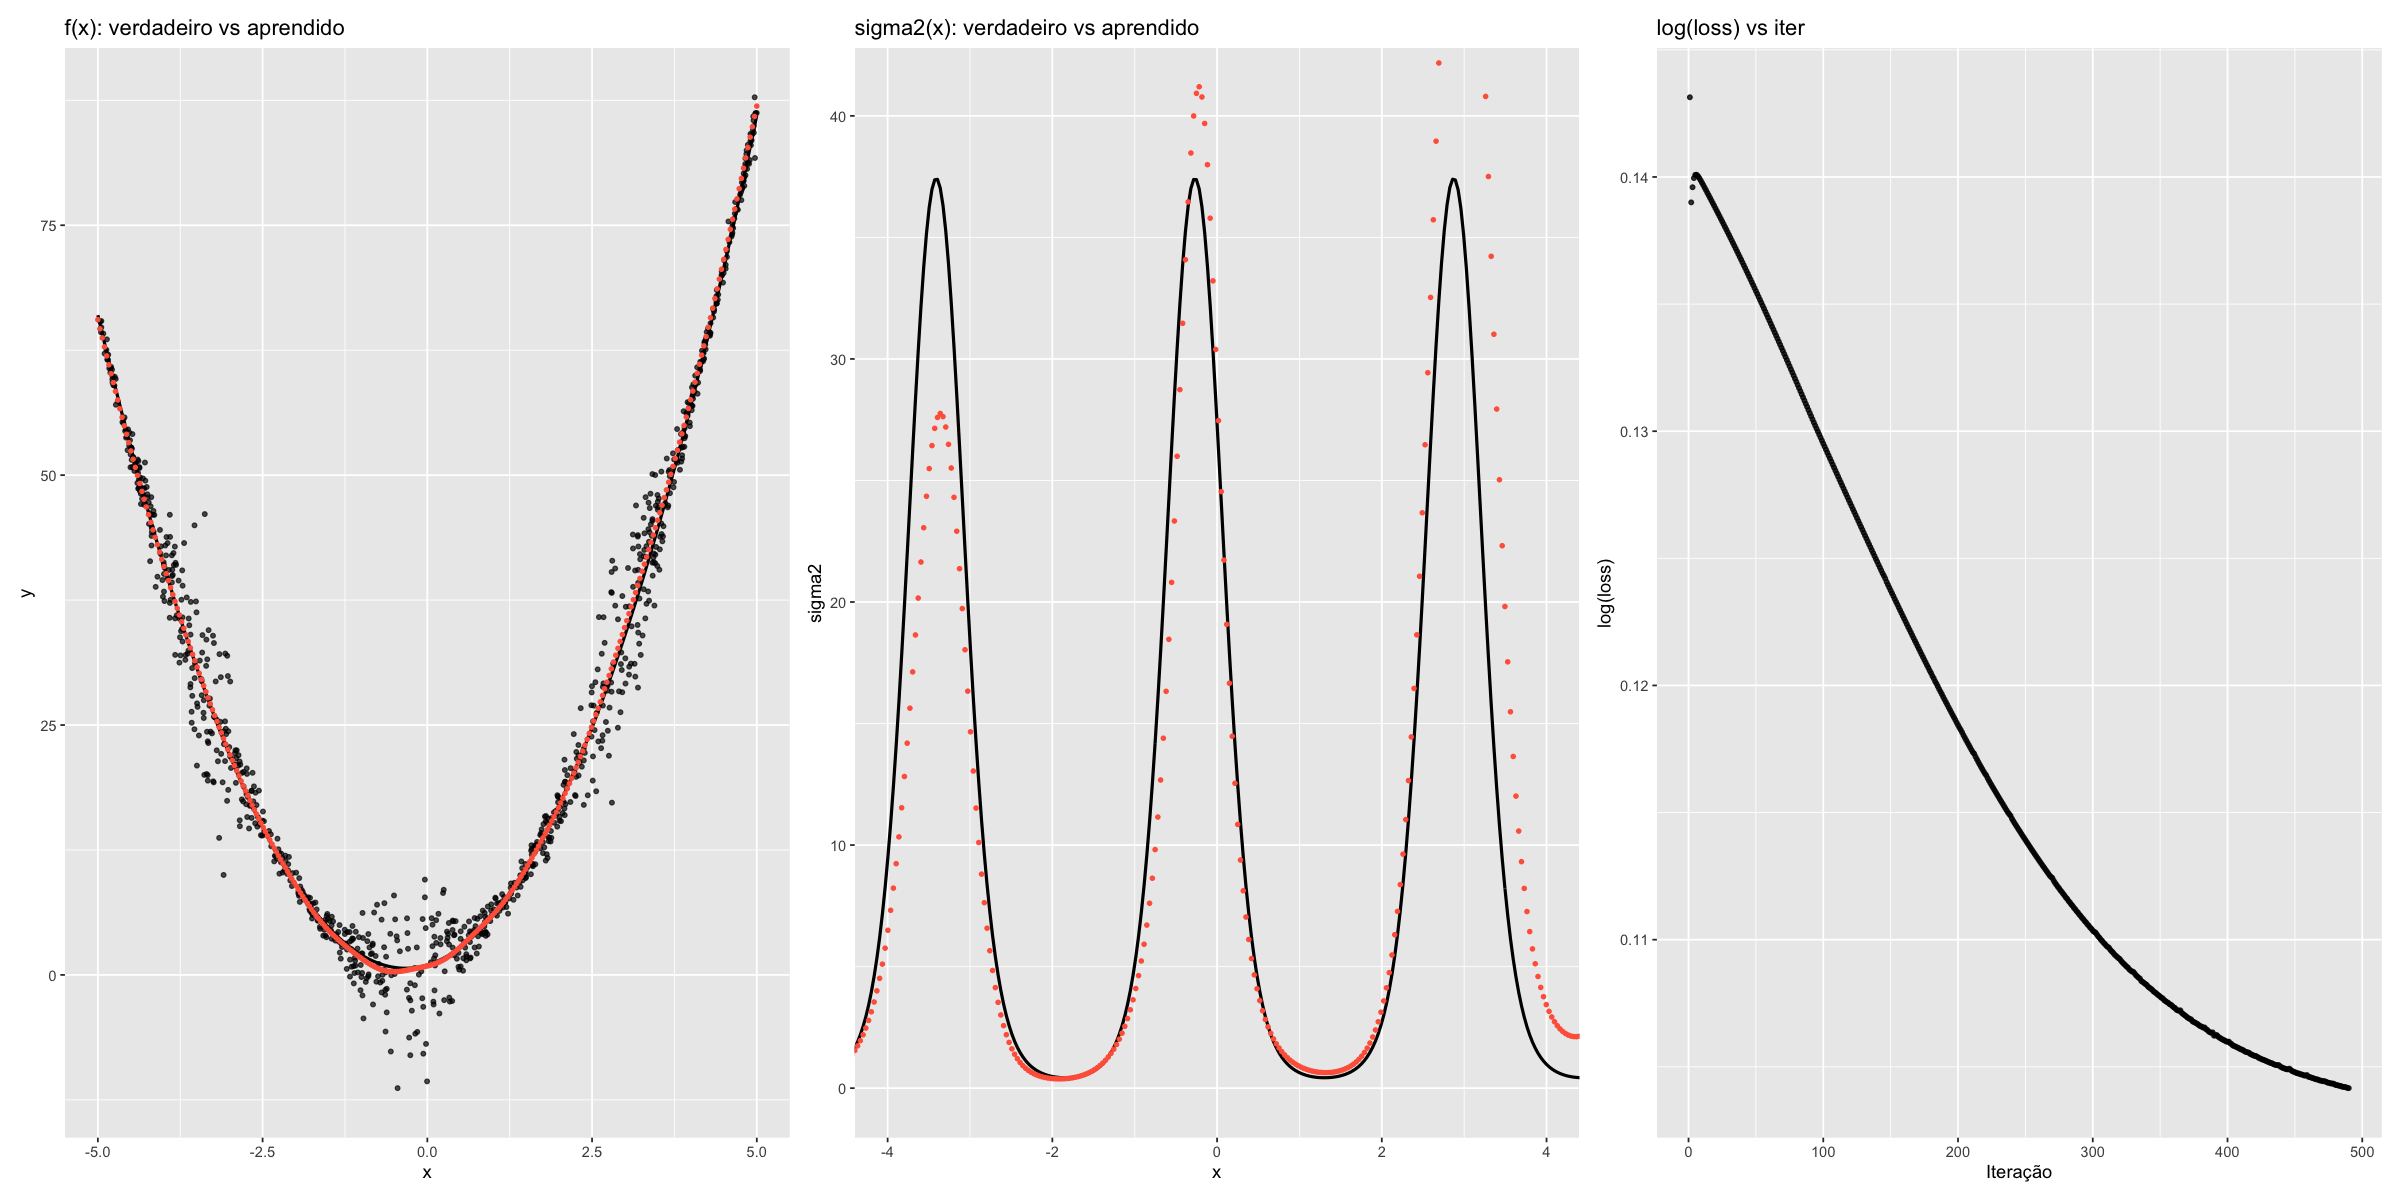


GIF gerado em:  regressao_train.gif 


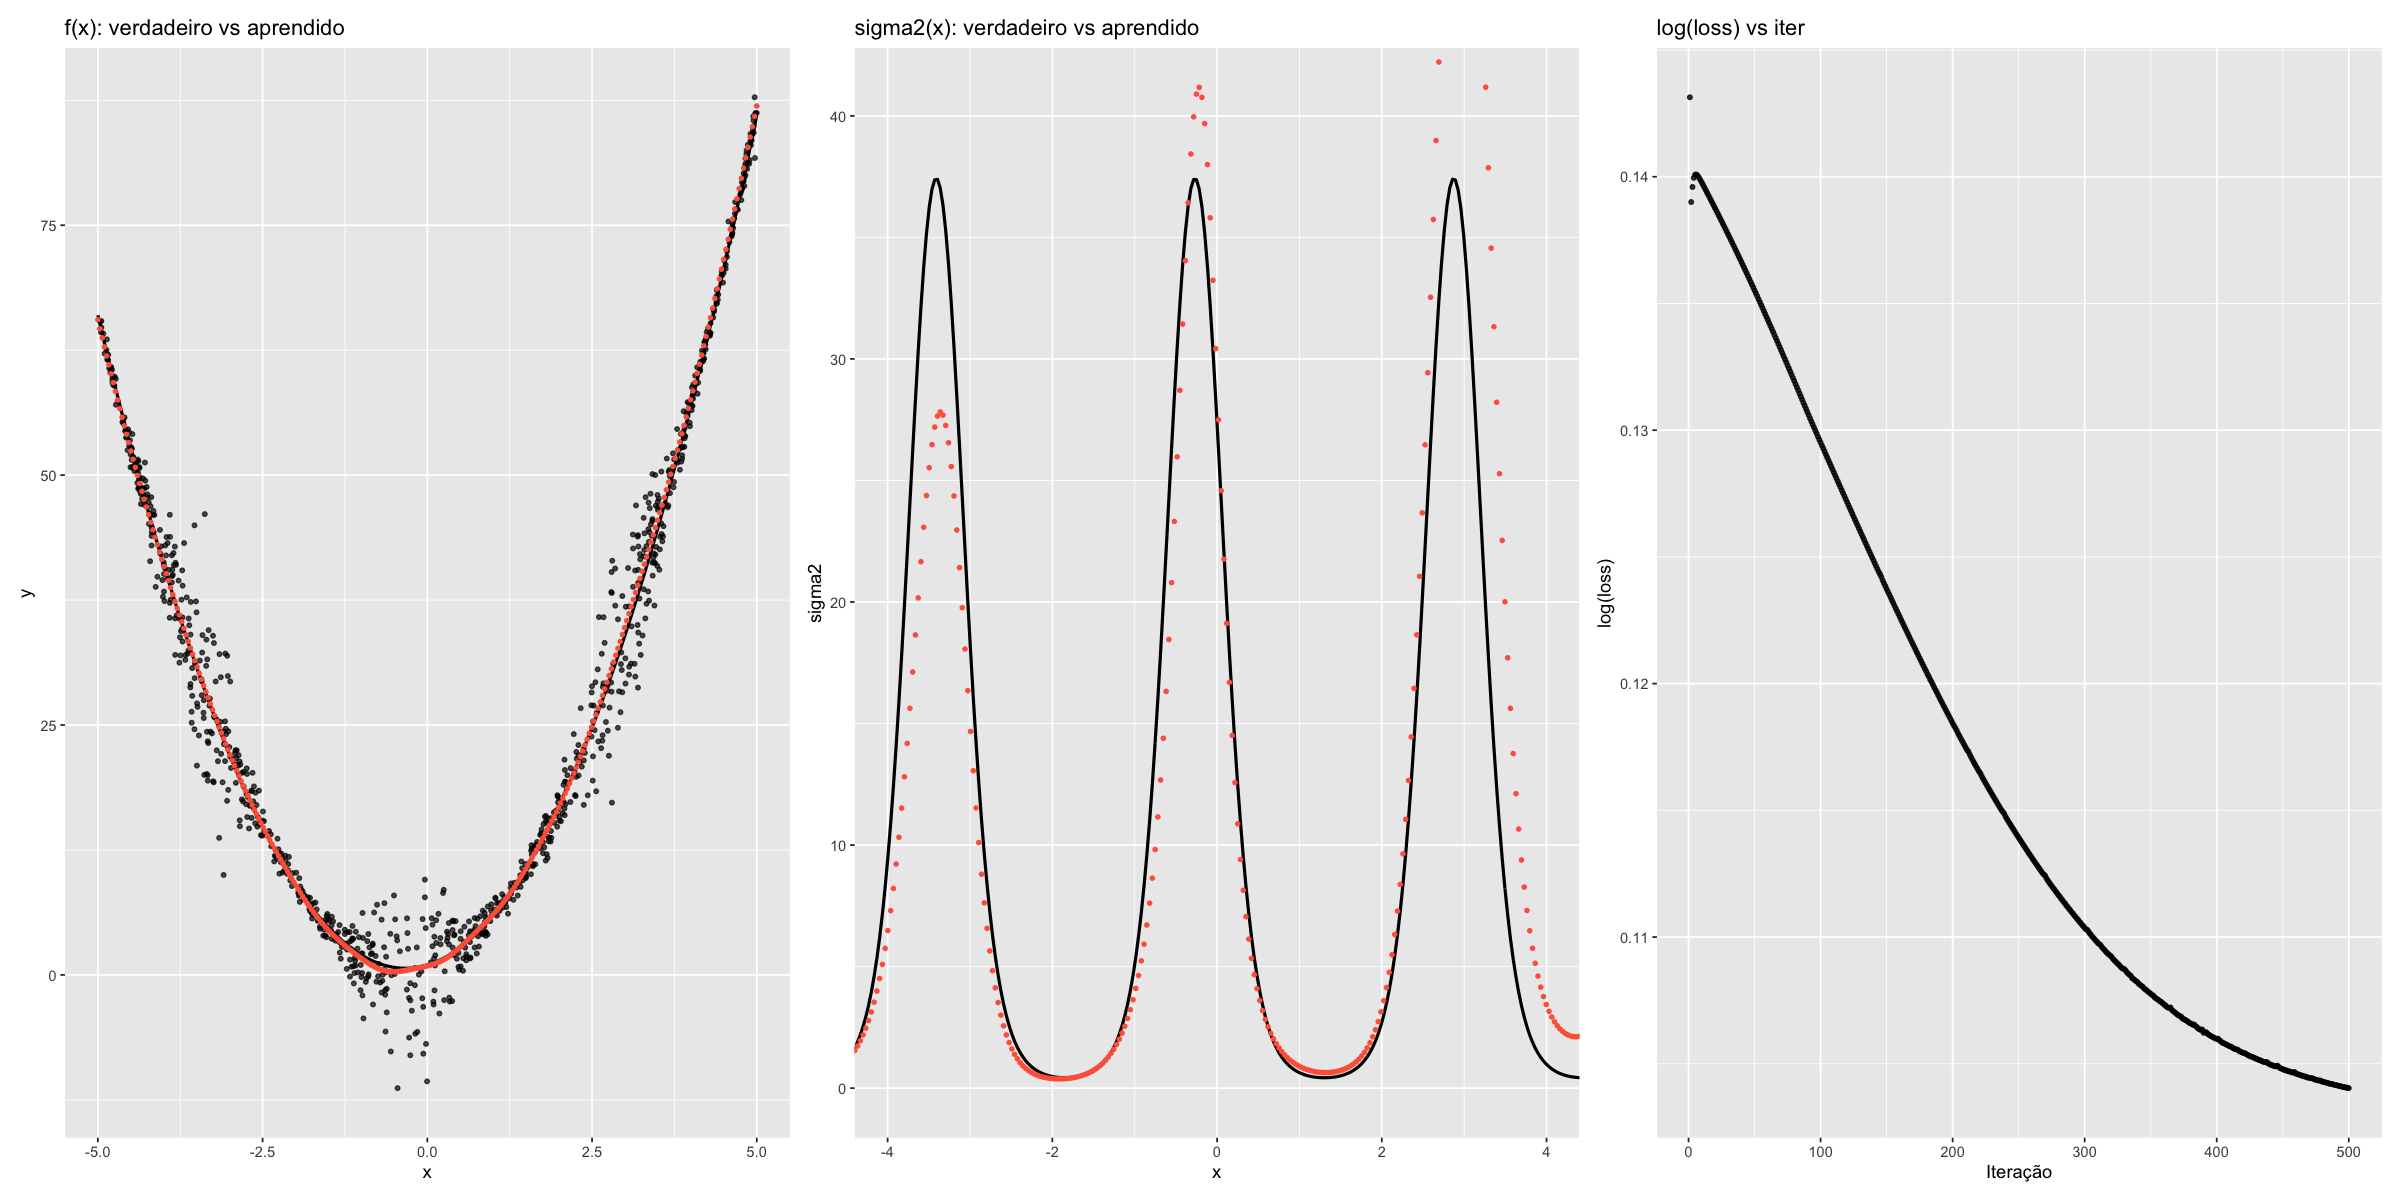

In [33]:
fit = estimacao(
  x, y, model,
  epochs = 500,
  print_each = 10,
  f = f,
  f_sigma2 = f_sigma2,
  make_gif = TRUE,
  gif_every = 10,
  gif_name = "regressao_train.gif"
)


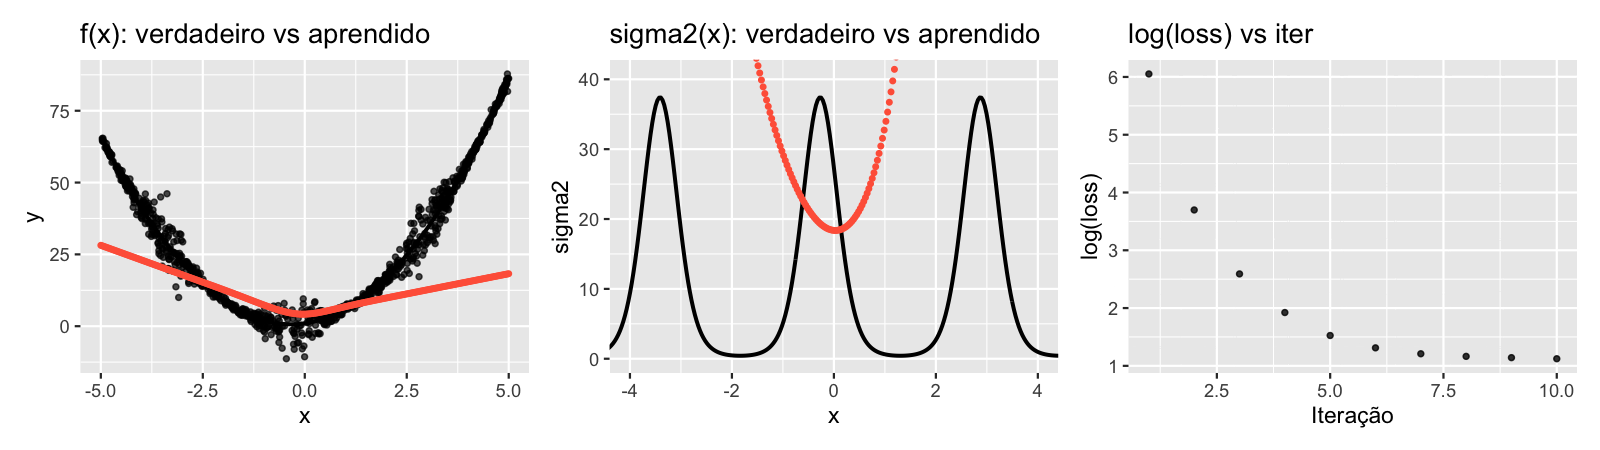

In [34]:
library(IRdisplay)
library(base64enc)

gif_path <- "regressao_train.gif"
gif_raw  <- readBin(gif_path, "raw", n = file.info(gif_path)$size)

gif_b64 <- base64enc::base64encode(gif_raw)

IRdisplay::display_html(
  sprintf(
    '<img src="data:image/gif;base64,%s" style="width:100%%; display:block; margin:auto;">',
    gif_b64
  )
)

In [ ]:
library(IRdisplay)

IRdisplay::display_html(HTML("
<style>
/* ====== Card base ====== */
.simcard {
  --ink: #1f2937;
  --muted: #6b7280;
  --bg0: #ffffff;
  --bg1: #fff5f5;
  --accent: #e06a5c;          /* seu vermelho */
  --accent2: #f69191;         /* nuance */
  --line: rgba(17, 24, 39, 0.08);

  border: 1px solid var(--line);
  border-top: 8px solid var(--accent);
  border-bottom: 8px solid var(--accent);
  background:
    radial-gradient(900px 240px at 20% -30%, rgba(255, 107, 107, 0.18), transparent 55%),
    linear-gradient(135deg, var(--bg1), var(--bg0));
  border-radius: 14px;
  padding: 18px 18px 14px 18px;
  font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', sans-serif;
  color: var(--ink);
  box-shadow:
    0 10px 30px rgba(17, 24, 39, 0.08),
    0 1px 0 rgba(255,255,255,0.8) inset;
}

/* ====== Header ====== */
.simcard__header{
  display: flex;
  align-items: flex-start;
  justify-content: space-between;
  gap: 12px;
  margin-bottom: 12px;
}

.simcard__title{
  font-size: 1.55em;
  font-weight: 750;
  letter-spacing: -0.02em;
  line-height: 1.15;
  margin: 0;
}

.simcard__subtitle{
  margin-top: 6px;
  color: var(--muted);
  font-size: 0.98em;
}

/* ====== Badges ====== */
.simcard__badges{
  display: flex;
  flex-wrap: wrap;
  gap: 8px;
  justify-content: flex-end;
  margin-top: 2px;
}

.badge{
  display: inline-flex;
  align-items: center;
  gap: 6px;
  font-size: 0.86em;
  padding: 6px 10px;
  border-radius: 999px;
  border: 1px solid rgba(192,57,43,0.25);
  background: rgba(255,255,255,0.75);
  color: #7c2d2d;
  backdrop-filter: blur(6px);
  box-shadow: 0 1px 0 rgba(255,255,255,0.7) inset;
}
.badge b { color: #4b1b1b; font-weight: 650; }
.badge .dot{
  width: 8px; height: 8px; border-radius: 999px;
  background: var(--accent);
  box-shadow: 0 0 0 3px rgba(192,57,43,0.10);
}

/* ====== Content grid ====== */
.simcard__grid{
  display: grid;
  grid-template-columns: 1.2fr 0.8fr;
  gap: 12px;
}

@media (max-width: 980px){
  .simcard__grid{ grid-template-columns: 1fr; }
}

/* ====== Panels ====== */
.panel{
  border: 1px solid rgba(17, 24, 39, 0.08);
  background: rgba(255,255,255,0.72);
  border-radius: 12px;
  padding: 12px 12px;
  box-shadow: 0 1px 0 rgba(255,255,255,0.7) inset;
}

.panel__title{
  display: flex;
  align-items: center;
  gap: 8px;
  font-weight: 750;
  font-size: 0.98em;
  color: #111827;
  margin: 0 0 8px 0;
}
.panel__title .pill{
  font-size: 0.78em;
  color: #7c2d2d;
  background: rgba(192,57,43,0.10);
  border: 1px solid rgba(192,57,43,0.18);
  padding: 2px 8px;
  border-radius: 999px;
  font-weight: 650;
}

.panel p{
  margin: 0;
  color: #374151;
  font-size: 1.02em;
  line-height: 1.55;
}

/* ====== Equation strip ====== */
.eqstrip{
  margin-top: 10px;
  border-radius: 10px;
  padding: 10px 12px;
  background: linear-gradient(135deg, rgba(31,41,55,0.04), rgba(192,57,43,0.06));
  border: 1px dashed rgba(192,57,43,0.25);
  color: #374151;
  font-size: 0.98em;
}
.eqstrip code{
  font-family: ui-monospace, Menlo, Consolas, monospace;
  font-size: 0.95em;
  background: rgba(255,255,255,0.9);
  padding: 2px 6px;
  border-radius: 8px;
  border: 1px solid rgba(17,24,39,0.08);
}

/* ====== List with icons ====== */
.ulx{
  list-style: none;
  padding: 0;
  margin: 0;
  display: grid;
  gap: 8px;
}
.li{
  display: flex;
  gap: 10px;
  align-items: flex-start;
  color: #374151;
  font-size: 1.0em;
  line-height: 1.45;
}
.ic{
  width: 26px;
  height: 26px;
  border-radius: 9px;
  display: grid;
  place-items: center;
  flex: 0 0 auto;
  background: rgba(192,57,43,0.10);
  border: 1px solid rgba(192,57,43,0.18);
  color: #7c2d2d;
  font-weight: 800;
}

/* ====== Footer row ====== */
.simcard__footer{
  margin-top: 12px;
  display: flex;
  flex-wrap: wrap;
  gap: 8px;
  align-items: center;
  justify-content: space-between;
  padding-top: 10px;
  border-top: 1px solid rgba(17,24,39,0.08);
  color: var(--muted);
  font-size: 0.92em;
}
.kv{
  display: inline-flex;
  align-items: center;
  gap: 6px;
}
.kv .k{
  color: #374151;
  font-weight: 650;
}
.tag{
  display: inline-flex;
  align-items: center;
  padding: 4px 8px;
  border-radius: 999px;
  border: 1px solid rgba(17,24,39,0.10);
  background: rgba(255,255,255,0.75);
  color: #4b5563;
  font-size: 0.86em;
}
</style>

<div class='simcard'>

  <div class='simcard__header'>
    <div>
      <h3 class='simcard__title'>Regressão Heteroscedástica com Redes Neurais</h3>
      <div class='simcard__subtitle'>
        Aprender simultaneamente a média condicional <i>f(x)</i> e a variância condicional <i>σ²(x)</i>.
      </div>
    </div>

    <div class='simcard__badges'>
      <span class='badge'><span class='dot'></span><b>Linguagem</b> R</span>
      <span class='badge'><span class='dot'></span><b>Framework</b> torch</span>
      <span class='badge'><span class='dot'></span><b>Ambiente</b> Jupyter</span>
    </div>
  </div>

  <div class='simcard__grid'>

    <div class='panel'>
      <div class='panel__title'>Objetivo <span class='pill'>modelagem</span></div>
      <p>
        Demonstrar a aprendizagem simultânea da média condicional
        <i>f(x)</i> e da variância condicional
        <i>σ²(x)</i> em um problema de regressão heteroscedástica.
      </p>

      <div class='eqstrip'>
        Saídas do modelo: <code>μ(x)</code> e <code>σ²(x)</code> &nbsp;→&nbsp; likelihood Gaussiana heteroscedástica.
      </div>
    </div>

    <div class='panel'>
      <div class='panel__title'>Características <span class='pill'>setup</span></div>
      <div class='ulx'>
        <div class='li'><div class='ic'>①</div><div>Dados sintéticos com ruído dependente da entrada</div></div>
        <div class='li'><div class='ic'>②</div><div>Rede neural com duas saídas: μ(x) e σ²(x)</div></div>
        <div class='li'><div class='ic'>③</div><div>Função de custo baseada em log-verossimilhança Gaussiana</div></div>
        <div class='li'><div class='ic'>④</div><div>Visualização dinâmica do treinamento e geração de GIF</div></div>
      </div>
    </div>

  </div>

  <div class='simcard__footer'>
    <div class='kv'><span class='k'>Artefatos:</span>
      <span class='tag'>curvas de loss</span>
      <span class='tag'>GIF</span>
      <span class='tag'>diagnósticos</span>
    </div>
  
  </div>

</div>
"))